In [1]:
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

In [2]:
# read in data and impute NaN's in y variable
data = pd.read_csv("enriched_county_data.csv")
data = data[data['EP_UNEMP'].notna()] # drops 54 rows with zero predictors
np.random.seed(100)
missing_y = np.random.randint(0, 16, size = data.shape[0])
imputed_y = np.where(data['COUNT'].isna(), missing_y/data['POPULATION']*100000, data['CRUDE_RATE'])
data = data.assign(CRUDE_RATE = imputed_y)

model_dict = {}

Variable descriptions:

    "FIPS", # unique county identifier
    "E_TOTPOP", # population count
    "E_PCI", # per-capita income
    "EP_UNEMP", # unemployment rate
    "EP_NOHSDP", # no high school diploma rate
    "EP_DISABL", # disabled rate
    "EP_MINRTY", # minority rate
    "EP_MUNIT", # 10+ units rate
    "EP_POV" # share below poverty

In [3]:
# split by incidence/mortality and weed out any bad data (proportion < 0)
data_incidence = data.loc[(data['EVENT_TYPE'] == 'Incidence')]
data_mortality = data.loc[(data['EVENT_TYPE'] == 'Mortality')]

# creating train and test sets for data_incidence set
train_i, test_i = train_test_split(data_incidence, train_size = 0.8, random_state = 100)

# creating train and test sets for data_mortality set
train_m, test_m = train_test_split(data_mortality, train_size = 0.8, random_state = 100)

predictors = ['E_PCI', 'EP_UNEMP', 'EP_NOHSDP', 'EP_DISABL', 'EP_MINRTY', 'EP_MUNIT', 'EP_POV']
predictor_labels = ['PER-CAPITA INCOME',
                    'UNEMPLOYMENT RATE',
                    'HIGH-SCHOOL DROPOUT RATE',
                    'DISABLED PERSONS RATE',
                    'MINORITY SHARE',
                    'SHARE CROWDED HOUSING UNITS',
                    'SHARE OF POP UNDER POVERTY LINE']

Text(0.5, 0.98, 'Relationship Between Predictors and Cancer Incidence/Mortality')

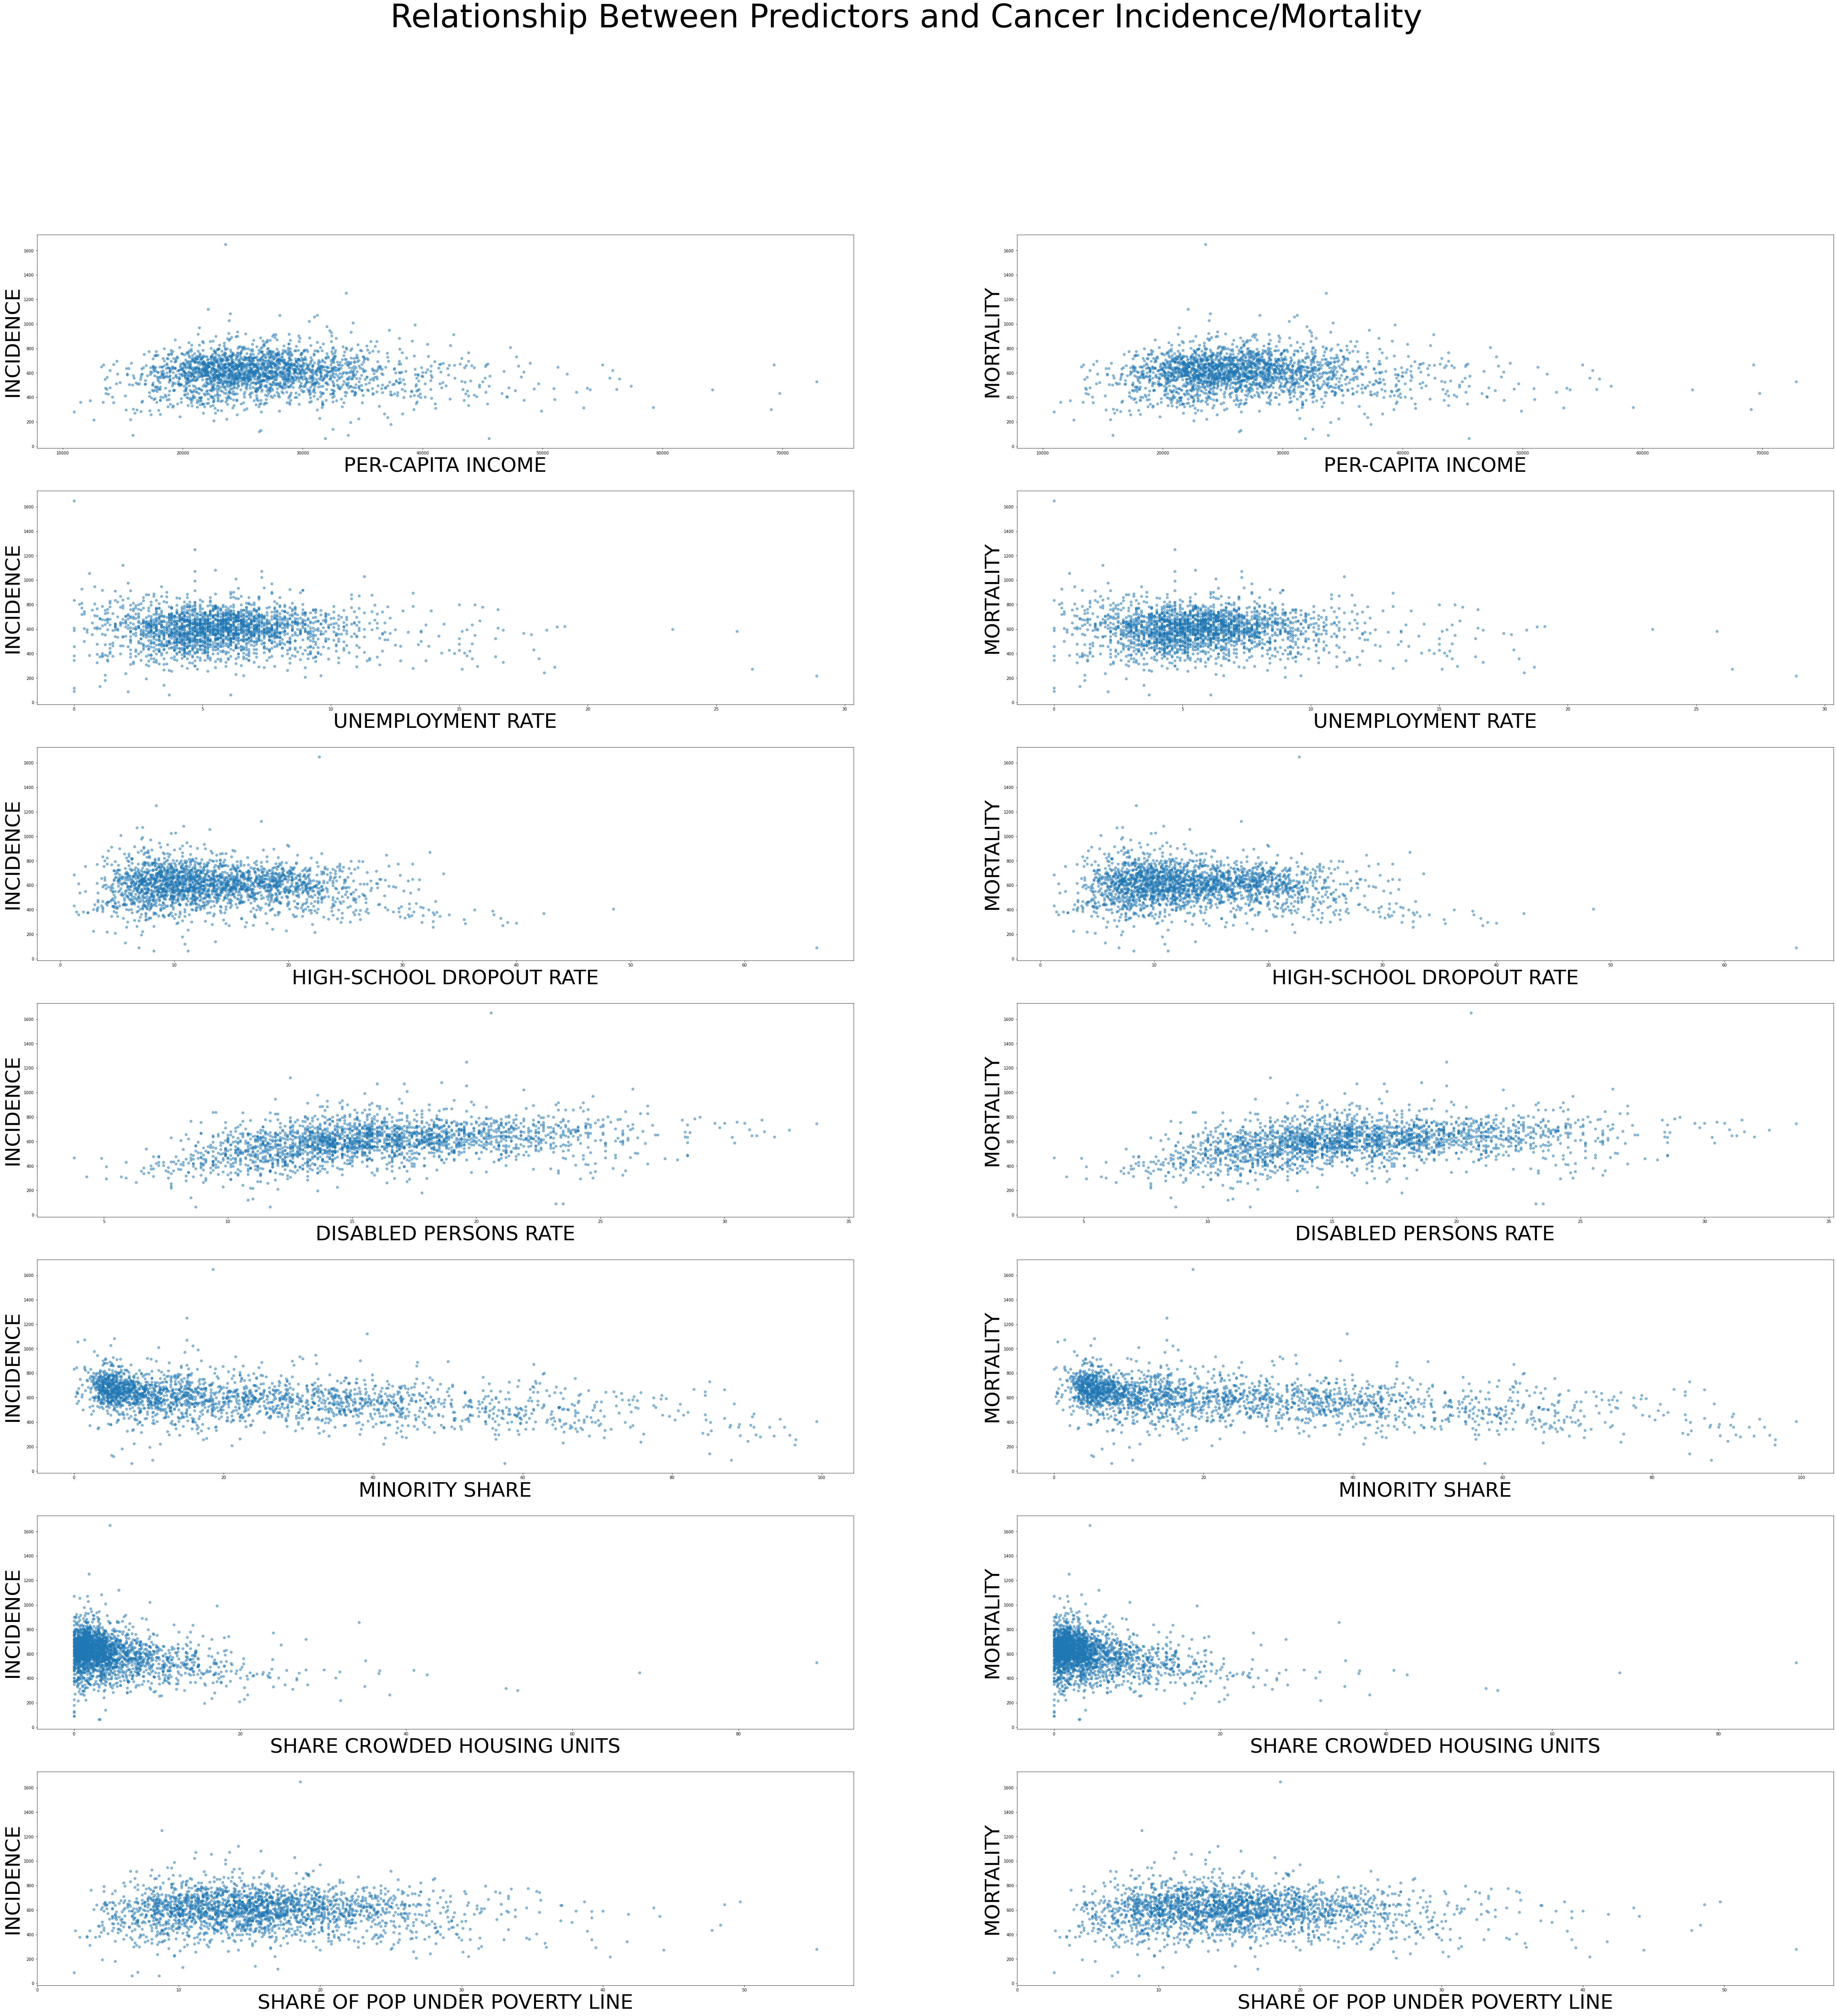

In [4]:
# plot all predictors
rownums = [x for x in range(7)]

fig,ax = plt.subplots(7,2, figsize=(80,80))

# weed out outlier for viz
eda_data = train_i[train_i['EP_POV'] >= 0]

for predictor, rownum in zip(predictors, rownums):
    ax[rownum,0].scatter(eda_data[predictor], eda_data['CRUDE_RATE'], alpha = 0.5)
    ax[rownum,0].set_ylabel('INCIDENCE', fontsize = 50)
    ax[rownum,0].set_xlabel(predictor_labels[rownum], fontsize = 50)
    ax[rownum,1].scatter(eda_data[predictor], eda_data['CRUDE_RATE'], alpha = 0.5)
    ax[rownum,1].set_ylabel('MORTALITY', fontsize = 50)
    ax[rownum,1].set_xlabel(predictor_labels[rownum], fontsize = 50)
    
plt.suptitle("Relationship Between Predictors and Cancer Incidence/Mortality", fontsize = 80)

In [6]:
# generating X and y train for incidence data
X_train_i = train_i[predictors]
y_train_i = train_i['CRUDE_RATE']

# generating X and y train for mortality data
X_train_m = train_m[predictors]
y_train_m = train_m['CRUDE_RATE']

# generating X and y test for incidence data
X_test_i = test_i[predictors]
y_test_i = test_i['CRUDE_RATE']

# generating X and y test for mortality data
X_test_m = test_m[predictors]
y_test_m = test_m['CRUDE_RATE']

# scale variables for polynomial regression
scaler_i = StandardScaler().fit(X_train_i)
X_train_i_scaled = scaler_i.transform(X_train_i)
X_test_i_scaled = scaler_i.transform(X_test_i)

scaler_m = StandardScaler().fit(X_train_m)
X_train_m_scaled = scaler_m.transform(X_train_m)
X_test_m_scaled = scaler_m.transform(X_test_m)

In [7]:
# cross-validate to find best degree 1-10
poly_mses_i = {}
poly_mses_m = {}

for i in range(1,11):
    
    print(i)

    degree = i
    transformer = PolynomialFeatures(degree, include_bias=False)

    new_train_features_i = transformer.fit_transform(X_train_i_scaled)
    new_train_features_m = transformer.fit_transform(X_train_m_scaled)
    model = LinearRegression()
    mse_score_i = cross_validate(model, new_train_features_i, y_train_i, cv = 10, scoring='neg_mean_squared_error', return_train_score = True)
    mse_score_m = cross_validate(model, new_train_features_m, y_train_m, cv = 10, scoring='neg_mean_squared_error', return_train_score = True)

    poly_mses_i[i] = [i, -mse_score_i['train_score'].mean(), -mse_score_i['test_score'].mean(), -mse_score_i['test_score'].mean()+abs(mse_score_i['test_score'].std()), -mse_score_i['test_score'].mean()-abs(mse_score_i['test_score'].std())]
    poly_mses_m[i] = [i, -mse_score_m['train_score'].mean(), -mse_score_m['test_score'].mean(), -mse_score_m['test_score'].mean()+abs(mse_score_m['test_score'].std()), -mse_score_m['test_score'].mean()-abs(mse_score_m['test_score'].std())]

1
2
3
4
5
6
7
8
9
10


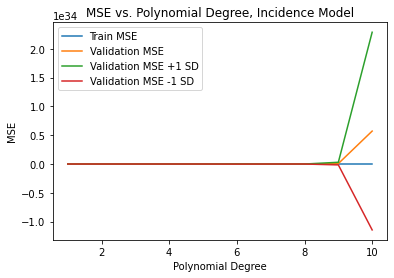

The degree with the best MSE for diagnosis is 1, which has a mean train MSE of 11597.645 and a mean validation MSE of 14641.046


In [8]:
# plot the test & train MSE
mse_df_i = pd.DataFrame(poly_mses_i).T.rename(columns={0:'deg', 1:'train', 2:'test', 3:'test_upper', 4:'test_lower'})

plt.plot(mse_df_i['deg'], mse_df_i['train'], label="Train MSE")
plt.plot(mse_df_i['deg'], mse_df_i['test'], label="Validation MSE")
plt.plot(mse_df_i['deg'], mse_df_i['test_upper'], label="Validation MSE +1 SD")
plt.plot(mse_df_i['deg'], mse_df_i['test_lower'], label="Validation MSE -1 SD")

# label the plots
plt.ylabel("MSE")
plt.xlabel("Polynomial Degree")
plt.title("MSE vs. Polynomial Degree, Incidence Model")
plt.legend()
plt.show()

# get best degree and its corresponding MSEs
mse_df_i = mse_df_i.sort_values(by='test')
best_deg_i = int(mse_df_i.head(n=1)['deg'])
best_val_mse_i = float(mse_df_i.head(n=1)['test'])
best_train_mse_i = float(mse_df_i.head(n=1)['train'])

print("The degree with the best MSE for diagnosis is " + str(best_deg_i) + ", which has a mean train MSE of " + str(round(best_train_mse_i, 3)) + " and a mean validation MSE of " + str(round(best_val_mse_i, 3)))

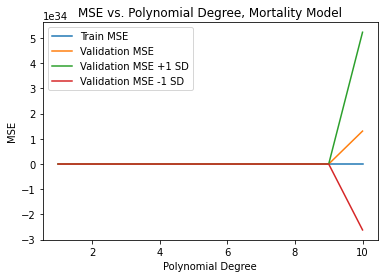

The degree with the best MSE for mortality is 1, which has a mean train MSE of 2137.681 and a mean validation MSE of 14641.046


In [9]:
# plot the test & train MSE
mse_df_m = pd.DataFrame(poly_mses_m).T.rename(columns={0:'deg', 1:'train', 2:'test', 3:'test_upper', 4:'test_lower'})

plt.plot(mse_df_m['deg'], mse_df_m['train'], label="Train MSE")
plt.plot(mse_df_m['deg'], mse_df_m['test'], label="Validation MSE")
plt.plot(mse_df_m['deg'], mse_df_m['test_upper'], label="Validation MSE +1 SD")
plt.plot(mse_df_m['deg'], mse_df_m['test_lower'], label="Validation MSE -1 SD")

# label your plots
plt.ylabel("MSE")
plt.xlabel("Polynomial Degree")
plt.title("MSE vs. Polynomial Degree, Mortality Model")
plt.legend()
plt.show()

# get best degree and its corresponding MSEs
mse_df_m = mse_df_m.sort_values(by='test')
best_deg_m = int(mse_df_m.head(n=1)['deg'])
best_val_mse_m = float(mse_df_m.head(n=1)['test'])
best_train_mse_m = float(mse_df_m.head(n=1)['train'])

print("The degree with the best MSE for mortality is " + str(best_deg_m) + ", which has a mean train MSE of " + str(round(best_train_mse_m, 3)) + " and a mean validation MSE of " + str(round(best_val_mse_i, 3)))

In [10]:
# train final polynomial models and report performance
transformer_i = PolynomialFeatures(degree = best_deg_i, include_bias = False)
transformer_m = PolynomialFeatures(degree = best_deg_m, include_bias = False)

new_train_features_i = transformer_i.fit_transform(X_train_i)
new_test_features_i = transformer_i.fit_transform(X_test_i)
new_train_features_m = transformer_m.fit_transform(X_train_m)
new_test_features_m = transformer_m.fit_transform(X_test_m)

model_i = LinearRegression()
model_i.fit(new_train_features_i, y_train_i)
model_m = LinearRegression()
model_m.fit(new_train_features_m, y_train_m)

y_pred_i = model_i.predict(new_test_features_i)
y_pred_m = model_m.predict(new_test_features_m)

y_pred_train_i = model_i.predict(new_train_features_i)
y_pred_train_m = model_m.predict(new_train_features_m)

mse_i = mean_squared_error(y_test_i, y_pred_i)
mse_m = mean_squared_error(y_test_m, y_pred_m)

r_squared_i = r2_score(y_test_i, y_pred_i)
r_squared_m = r2_score(y_test_m, y_pred_m)

model_dict["polynomial_incidence"] = [mse_i, r_squared_i]
model_dict["polynomial_mortality"] = [mse_m, r_squared_m]

print("The test MSE on the diagnosis model is", str(round(mse_i, 3)), "and the train MSE is", str(round(mean_squared_error(y_pred_train_i, y_train_i), 3)))
print("The R-squared on the diagnosis model is", round(r_squared_i,3))
print("The test MSE on the mortality model is", str(round(mse_m, 3)), "and the train MSE is", str(round(mean_squared_error(y_pred_train_m, y_train_m), 3)))
print("The R-squared on the mortality model is", round(r_squared_m,3))

print("MORTALITY COEFFICIENTS:")
for predictor, coefficient in zip(predictors, range(len(predictors))):
    print(predictor, round(model_m.coef_[coefficient],2))
    
print("INCIDENCE COEFFICIENTS:")
for predictor, coefficient in zip(predictors, range(len(predictors))):
    print(predictor, round(model_i.coef_[coefficient],2))

The test MSE on the diagnosis model is 10996.431 and the train MSE is 11606.533
The R-squared on the diagnosis model is 0.394
The test MSE on the mortality model is 3087.628 and the train MSE is 2138.603
The R-squared on the mortality model is 0.343
MORTALITY COEFFICIENTS:
E_PCI 0.0
EP_UNEMP -1.12
EP_NOHSDP -0.64
EP_DISABL 6.97
EP_MINRTY -0.79
EP_MUNIT -2.0
EP_POV 1.1
INCIDENCE COEFFICIENTS:
E_PCI 0.0
EP_UNEMP -1.66
EP_NOHSDP -2.15
EP_DISABL 11.97
EP_MINRTY -1.89
EP_MUNIT -4.23
EP_POV 1.64


In [11]:
# cross-validate to find alpha
alphas = [10**i for i in range(-3, 10, 1)]
lasso_mses_i = {}
lasso_mses_m = {}

for i in alphas:
    model = Lasso(alpha = i, normalize = True, random_state = 100)
    mse_score_i = cross_validate(model, new_train_features_i, y_train_i, cv = 10, scoring='neg_mean_squared_error', return_train_score = True)
    lasso_mses_i[i] = [i, -mse_score_i['train_score'].mean(), -mse_score_i['test_score'].mean(), -mse_score_i['test_score'].mean()+abs(mse_score_i['test_score'].std()), -mse_score_i['test_score'].mean()-abs(mse_score_i['test_score'].std())]
    mse_score_m = cross_validate(model, new_train_features_m, y_train_m, cv = 10, scoring='neg_mean_squared_error', return_train_score = True)
    lasso_mses_m[i] = [i, -mse_score_m['train_score'].mean(), -mse_score_m['test_score'].mean(), -mse_score_m['test_score'].mean()+abs(mse_score_m['test_score'].std()), -mse_score_m['test_score'].mean()-abs(mse_score_m['test_score'].std())]

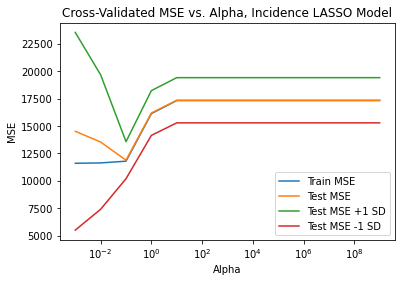

The alpha with the best MSE is 0.1, which has a validation MSE of 11879.912 and a train MSE of 11787.917


In [12]:
# plot the test & train MSE
mse_df_lasso_i = pd.DataFrame(lasso_mses_i).T.rename(columns={0:'alpha', 1:'train', 2:'test', 3:'test_upper', 4:'test_lower'})
plt.plot(mse_df_lasso_i['alpha'], mse_df_lasso_i['train'], label="Train MSE")
plt.plot(mse_df_lasso_i['alpha'], mse_df_lasso_i['test'], label="Test MSE")
plt.plot(mse_df_lasso_i['alpha'], mse_df_lasso_i['test_upper'], label="Test MSE +1 SD")
plt.plot(mse_df_lasso_i['alpha'], mse_df_lasso_i['test_lower'], label="Test MSE -1 SD")

# label your plots
plt.ylabel("MSE")
plt.xlabel("Alpha")
plt.title("Cross-Validated MSE vs. Alpha, Incidence LASSO Model")
plt.xscale('log')
plt.legend()
plt.show()

# get best alpha and its corresponding MSEs
mse_df_lasso_i = mse_df_lasso_i.sort_values(by='test')
best_alpha_i = float(mse_df_lasso_i.head(n=1)['alpha'])
best_test_mse_i = round(float(mse_df_lasso_i.head(n=1)['test']), 3)
best_train_mse_i = round(float(mse_df_lasso_i.head(n=1)['train']), 3)
print("The alpha with the best MSE is " + str(best_alpha_i) + ", which has a validation MSE of " + str(best_test_mse_i) + " and a train MSE of " + str(best_train_mse_i))      

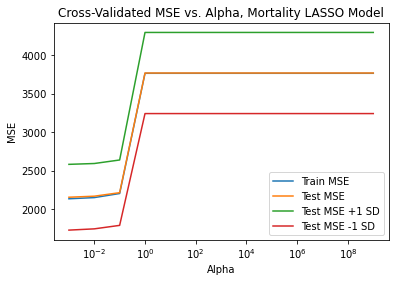

The alpha with the best MSE is 0.001, which has a validation MSE of 2158.151 and a train MSE of 11787.917


In [13]:
# plot the test & train MSE
mse_df_lasso_m = pd.DataFrame(lasso_mses_m).T.rename(columns={0:'alpha', 1:'train', 2:'test', 3:'test_upper', 4:'test_lower'})
plt.plot(mse_df_lasso_m['alpha'], mse_df_lasso_m['train'], label="Train MSE")
plt.plot(mse_df_lasso_m['alpha'], mse_df_lasso_m['test'], label="Test MSE")
plt.plot(mse_df_lasso_m['alpha'], mse_df_lasso_m['test_upper'], label="Test MSE +1 SD")
plt.plot(mse_df_lasso_m['alpha'], mse_df_lasso_m['test_lower'], label="Test MSE -1 SD")

# label your plots
plt.ylabel("MSE")
plt.xlabel("Alpha")
plt.title("Cross-Validated MSE vs. Alpha, Mortality LASSO Model")
plt.xscale('log')
plt.legend()
plt.show()

# get best alpha and its corresponding MSEs
mse_df_lasso_m = mse_df_lasso_m.sort_values(by='test')
best_alpha_m = float(mse_df_lasso_m.head(n=1)['alpha'])
best_test_mse_m = round(float(mse_df_lasso_m.head(n=1)['test']), 3)
best_train_mse_m = round(float(mse_df_lasso_m.head(n=1)['train']), 3)
print("The alpha with the best MSE is " + str(best_alpha_m) + ", which has a validation MSE of " + str(best_test_mse_m) + " and a train MSE of " + str(best_train_mse_i)) 

In [14]:
# train final LASSO models and report performance
model_i = Lasso(alpha = best_alpha_i, normalize = True, random_state = 100)
model_m = Lasso(alpha = best_alpha_m, normalize = True, random_state = 100)

model_i.fit(new_train_features_i, y_train_i)
model_m.fit(new_train_features_m, y_train_m)

y_pred_i = model_i.predict(new_test_features_i)
y_pred_m = model_m.predict(new_test_features_m)

y_pred_train_i = model_i.predict(new_train_features_i)
y_pred_train_m = model_m.predict(new_train_features_m)

mse_i = mean_squared_error(y_test_i, y_pred_i)
mse_m = mean_squared_error(y_test_m, y_pred_m)

r_squared_i = r2_score(y_test_i, y_pred_i)
r_squared_m = r2_score(y_test_m, y_pred_m)

model_dict["lasso_incidence"] = [mse_i, r_squared_i]
model_dict["lasso_mortality"] = [mse_m, r_squared_m]

print("The test MSE on the diagnosis model is", str(round(mse_i, 3)), "and the train MSE is", str(round(mean_squared_error(y_pred_train_i, y_train_i), 3)))
print("The R-squared on the diagnosis model is", round(r_squared_i,3))
print("The test MSE on the mortality model is", str(round(mse_m, 3)), "and the train MSE is", str(round(mean_squared_error(y_pred_train_m, y_train_m), 3)))
print("The R-squared on the mortality model is", round(r_squared_m,3))

The test MSE on the diagnosis model is 11264.117 and the train MSE is 11809.261
The R-squared on the diagnosis model is 0.379
The test MSE on the mortality model is 3085.608 and the train MSE is 2139.059
The R-squared on the mortality model is 0.343


In [15]:
# get cross-validated tree depth for incidence decision tree
cvmeans = {}
train_scores = {}
cv_scores_all = {}
depths = list(range(1,21))

for i in depths:
    
    # decision tree and score for full train set
    #tree_i = DecisionTreeRegressor(max_depth=i)
    #model1.fit(X_train_i,y_train_i)
    #model1_scores = model1.score(X_train,y_train)
    #train_scores[i] = model1_scores
    
    # CV
    tree_i = DecisionTreeRegressor(max_depth=i, random_state = 100)
    
    tree_i.fit(X_train_i,y_train_i)
    y_preds_train = tree_i.predict(X_train_i)
    train_scores[i] = mean_squared_error(y_train_i,y_preds_train)
    
    scores = cross_val_score(tree_i, X_train_i, y_train_i, cv=10, scoring="neg_mean_squared_error")
    #scores = cross_val_score(estimator=tree_i, X=X_train_i, y=y_train_i, cv=10, n_jobs=-1)

    cvmeans[i] = -1*scores.mean()
    cv_scores_all[i] = scores

# making list of standard deviations
cvstds = np.array([np.std(scores) for scores in cv_scores_all.values()])

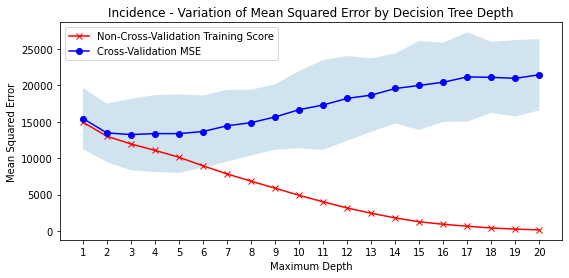

In [16]:
# plot decision tree depths for incidence and corresponding performance
x = list(cvmeans.keys())
y = list(cvmeans.values())

x_fulltrain = list(train_scores.keys())
y_fulltrain = list(train_scores.values())

plt.figure(figsize = (9,4))
plt.plot(x_fulltrain, y_fulltrain, 'r-', marker = 'x', label = 'Non-Cross-Validation Training Score')
plt.fill_between(x, y + (2*cvstds), y - (2*cvstds), alpha=0.2)
#Plot
plt.ylabel("Mean Squared Error")
plt.xlabel("Maximum Depth")
plt.title('Incidence - Variation of Mean Squared Error by Decision Tree Depth')
plt.plot(x, y, 'b-', marker='o', label = 'Cross-Validation MSE')
plt.xticks(depths)
plt.legend(loc="upper left")
plt.show()

In [17]:
# train full decision tree for incidence and report performance
min_mse = min(y)
best_depth_i = x[y.index(min(y))]

best_tree = DecisionTreeRegressor(max_depth=best_depth_i)
best_tree.fit(X_train_i,y_train_i)
y_pred_test = best_tree.predict(X_test_i)

test_score = best_tree.score(X_test_i, y_test_i)
train_score = best_tree.score(X_train_i, y_train_i)
test_mse = mean_squared_error(y_test_i, y_pred_test)

model_dict["decision_tree_incidence"] = [test_mse, test_score]

print(f"The best depth found through cross validation was {best_depth_i}, which corresponded to a validation mean-squared \nerror value of {min_mse:.2f}.")
print(f"The resulting test score with for a decision tree of this depth is {test_score:.4f}. \nThe resulting test MSE is {test_mse:.4f}")

The best depth found through cross validation was 3, which corresponded to a validation mean-squared 
error value of 13242.27.
The resulting test score with for a decision tree of this depth is 0.3254. 
The resulting test MSE is 12240.1191


In [18]:
# repeating above decision tree using mortality data
cvmeans = {}
train_scores = {}
cv_scores_all = {}
depths = list(range(1,21))

for i in depths:
    
    # decision tree and score for full train set
    #tree_i = DecisionTreeRegressor(max_depth=i)
    #model1.fit(X_train_i,y_train_i)
    #model1_scores = model1.score(X_train,y_train)
    #train_scores[i] = model1_scores
    
    # CV
    tree_m = DecisionTreeRegressor(max_depth=i, random_state=100)
    
    tree_m.fit(X_train_m,y_train_m)
    y_preds_train = tree_m.predict(X_train_m)
    train_scores[i] = mean_squared_error(y_train_m,y_preds_train)
    
    scores = cross_val_score(tree_m, X_train_m, y_train_m, cv=10, scoring="neg_mean_squared_error")
    #scores = cross_val_score(estimator=tree_i, X=X_train_i, y=y_train_i, cv=10, n_jobs=-1)

    cvmeans[i] = -1*scores.mean()
    cv_scores_all[i] = scores

# making list of standard deviations
cvstds = np.array([np.std(scores) for scores in cv_scores_all.values()])

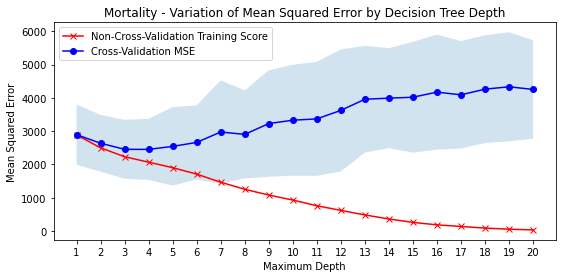

In [19]:
# plot decision tree depths for mortality and corresponding performance
x = list(cvmeans.keys())
y = list(cvmeans.values())

x_fulltrain = list(train_scores.keys())
y_fulltrain = list(train_scores.values())

plt.figure(figsize = (9,4))
plt.fill_between(x, y + (2*cvstds), y - (2*cvstds), alpha=0.2)
plt.plot(x_fulltrain, y_fulltrain, 'r-', marker = 'x', label = 'Non-Cross-Validation Training Score')
#Plot
plt.ylabel("Mean Squared Error")
plt.xlabel("Maximum Depth")
plt.title('Mortality - Variation of Mean Squared Error by Decision Tree Depth')
plt.plot(x, y, 'b-', marker='o', label = 'Cross-Validation MSE')
plt.xticks(depths)
plt.legend(loc="upper left")
plt.show()

In [20]:
# train full decision tree for mortality and report performance
min_mse = min(y)
best_depth_m = x[y.index(min(y))]

best_tree = DecisionTreeRegressor(max_depth=best_depth_m)
best_tree.fit(X_train_m,y_train_m)
y_pred_test = best_tree.predict(X_test_m)

test_score = best_tree.score(X_test_m, y_test_m)
train_score = best_tree.score(X_train_m, y_train_m)
test_mse = mean_squared_error(y_test_m, y_pred_test)

model_dict["decision_tree_mortality"] = [test_mse, test_score]

print(f"The best depth found through cross validation was {best_depth_m}, which corresponded to a validation mean-squared \nerror value of {min_mse:.2f}.")
print(f"The resulting test score with for a decision tree of this depth is {test_score:.4f}. \nThe resulting test MSE is {test_mse:.4f}")

The best depth found through cross validation was 4, which corresponded to a validation mean-squared 
error value of 2453.35.
The resulting test score with for a decision tree of this depth is 0.2908. 
The resulting test MSE is 3332.2793


In [21]:
# get cross-validated tree depth for incidence random forest
test_scores = {}
train_scores = {}
test_mse_dict = {}
depths = list(range(1,21))


for i in depths:
    model_forest = RandomForestRegressor(n_estimators=50, max_depth=i, random_state = 109)
    model_forest.fit(X_train_i, y_train_i)

    y_pred_train = model_forest.predict(X_train_i)
    y_pred_test = model_forest.predict(X_test_i)

    test_score = model_forest.score(X_test_i, y_test_i)
    train_score = model_forest.score(X_train_i, y_train_i)
    test_mse = mean_squared_error(y_test_i, y_pred_test)

    test_scores[i] = test_score
    train_scores[i] = train_score
    test_mse_dict[i] = test_mse

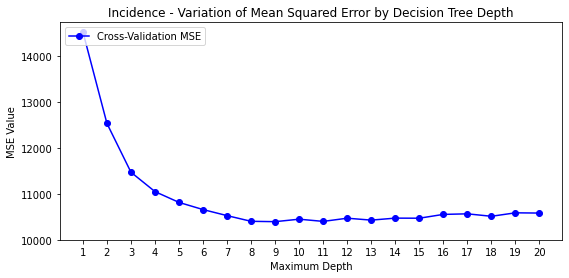

In [22]:
# plot tree depths and corresponding performance for incidence random forest
x = list(test_scores.keys())
y = list(test_scores.values())

x_mse = list(test_mse_dict.keys())
y_mse = list(test_mse_dict.values())

plt.figure(figsize = (9,4))
#Plot
plt.ylabel("MSE Value")
plt.xlabel("Maximum Depth")
plt.title('Incidence - Variation of Mean Squared Error by Decision Tree Depth')
plt.plot(x_mse, y_mse, 'b-', marker='o', label = 'Cross-Validation MSE')
plt.xticks(depths)
plt.yticks(np.arange(10000,15000,1000))
plt.legend(loc="upper left")
plt.show()

In [23]:
# train full random forest for incidence and report performance
max_score = max(y)
best_depth_i = x[y.index(max(y))]
min_mse = min(test_mse_dict.values())

model_dict["random_forest_incidence"] = [min_mse, max_score]

print(f"The best baseline tree depth found was {best_depth_i}, which corresponded to an r-squared value of {max_score:.4f} \nand an MSE of {min_mse:.3f}.")

The best baseline tree depth found was 9, which corresponded to an r-squared value of 0.4271 
and an MSE of 10394.164.


In [24]:
# get cross-validated tree depth for mortality random forest
test_scores = {}
train_scores = {}
test_mse_dict = {}
depths = list(range(1,21))


for i in depths:
    model_forest = RandomForestRegressor(n_estimators=50, max_depth=i, random_state = 109)
    model_forest.fit(X_train_m, y_train_m)

    y_pred_train = model_forest.predict(X_train_m)
    y_pred_test = model_forest.predict(X_test_m)

    test_score = model_forest.score(X_test_m, y_test_m)
    train_score = model_forest.score(X_train_m, y_train_m)
    test_mse = mean_squared_error(y_test_m, y_pred_test)

    test_scores[i] = test_score
    train_scores[i] = train_score
    test_mse_dict[i] = test_mse

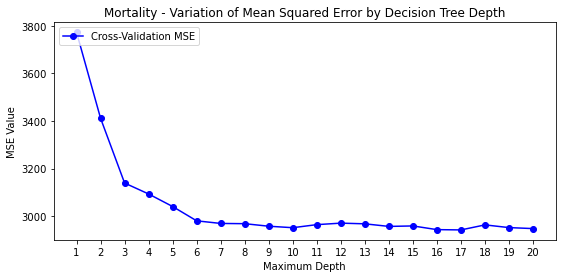

In [25]:
# plot tree depths and corresponding performance for mortality random forest
x = list(test_scores.keys())
y = list(test_scores.values())

x_mse = list(test_mse_dict.keys())
y_mse = list(test_mse_dict.values())

plt.figure(figsize = (9,4))
#Plot
plt.ylabel("MSE Value")
plt.xlabel("Maximum Depth")
plt.title('Mortality - Variation of Mean Squared Error by Decision Tree Depth')
plt.plot(x_mse, y_mse, 'b-', marker='o', label = 'Cross-Validation MSE')
plt.xticks(depths)
#plt.yticks(np.arange(3000,3800,200))
plt.legend(loc="upper left")
plt.show()

In [26]:
# train full random forest for mortality and report performance
max_score = max(y)
best_depth_m = x[y.index(max(y))]
min_mse = min(test_mse_dict.values())

model_dict["random_forest_mortality"] = [min_mse, max_score]

print(f"The best baseline tree depth found was {best_depth_m}, which corresponded to an r-squared value of {max_score:.4f} \nand an MSE of {min_mse:.3f}.")

The best baseline tree depth found was 17, which corresponded to an r-squared value of 0.3738 
and an MSE of 2942.509.


In [27]:
# find best number of bootstraps
mse_tra_i, mse_tst_i, mse_tra_m, mse_tst_m = [], [], [], []

for boot in np.arange(1,31):
    # Initializing bagging models for incidence and mortality with the respective number of bootstraps
    model_i = BaggingRegressor(DecisionTreeRegressor(max_depth=9),
                         n_estimators=boot,
                        random_state=3)
    model_m = BaggingRegressor(DecisionTreeRegressor(max_depth=9),
                         n_estimators=boot,
                        random_state=3)
    
    # Fitting the incidence and mortality models
    model_i.fit(X_train_i, y_train_i)
    model_m.fit(X_train_m, y_train_m)
    
    # Appending train and test MSE values to the respective lists
    mse_tst_i.append(mean_squared_error(y_test_i,model_i.predict(X_test_i)))
    mse_tra_i.append(mean_squared_error(y_train_i,model_i.predict(X_train_i)))
    mse_tst_m.append(mean_squared_error(y_test_m,model_m.predict(X_test_m)))
    mse_tra_m.append(mean_squared_error(y_train_m,model_m.predict(X_train_m)))

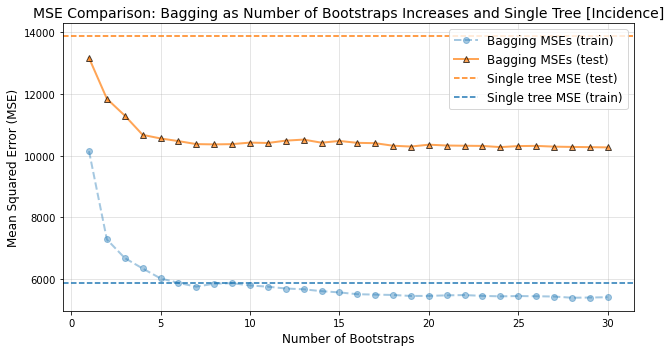

In [28]:
## INCIDENCE
# Fitting a single tree here to demonstrate a baseline for the bagging results 
single_tree = DecisionTreeRegressor(max_depth=9).fit(X_train_i, y_train_i)
single_tree_train_score = mean_squared_error(y_train_i,single_tree.predict(X_train_i))
single_tree_test_score = mean_squared_error(y_test_i,single_tree.predict(X_test_i))

# Plotting the obtained MSE values for each number of bootstraps, as well as the single tree train and test scores
plt.figure(figsize=(9, 5))

# Plotting bootstrapped train incidence MSEs
plt.plot(
    range(1,31),
    mse_tra_i,
    "o--",
    color="tab:blue",
    alpha=0.4,
    linewidth=2,
    label=f"Bagging MSEs (train)",
)
# Plotting bootstrapped test incidence MSEs
plt.plot(
    range(1,31),
    mse_tst_i,
    "^-",
    markeredgecolor="k",
    color="tab:orange",
    alpha=0.7,
    linewidth=2,
    label=f"Bagging MSEs (test)",
)
# Plotting single tree test incidence MSE
plt.axhline(
    single_tree_test_score,
    linestyle="--",
    color="tab:orange",
    label=f"Single tree MSE (test)"
)
# Plotting single tree train incidence MSE
plt.axhline(
    single_tree_train_score,
    linestyle="--",
    color="tab:blue",
    label=f"Single tree MSE (train)"
)

plt.xlabel("Number of Bootstraps", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title(
    "MSE Comparison: Bagging as Number of Bootstraps Increases and Single Tree [Incidence]",
    fontsize=14
)
plt.legend(loc="best", fontsize=12)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show()

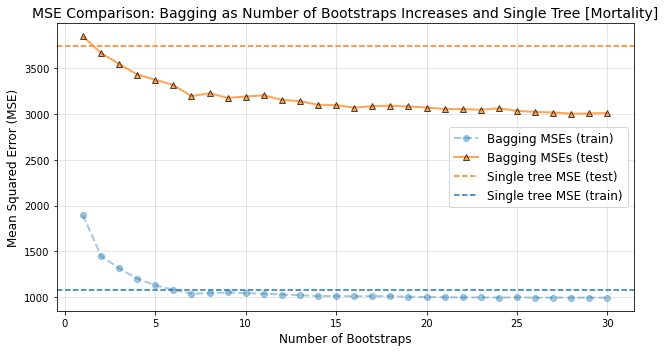

In [29]:
## MORTALITY
# Fitting a single tree here to demonstrate a baseline for the bagging results
single_tree = DecisionTreeRegressor(
    max_depth=9).fit(X_train_m, y_train_m)
single_tree_train_score = mean_squared_error(y_train_m,single_tree.predict(X_train_m))
single_tree_test_score = mean_squared_error(y_test_m,single_tree.predict(X_test_m))

# Plotting the obtained MSE values for each number of bootstraps, as well as the single tree train and test scores
plt.figure(figsize=(9, 5))

# Plotting bootstrapped train mortality MSEs
plt.plot(
    range(1,31),
    mse_tra_m,
    "o--",
    color="tab:blue",
    alpha=0.4,
    linewidth=2,
    label=f"Bagging MSEs (train)",
)
# Plotting bootstrapped test mortality MSEs
plt.plot(
    range(1,31),
    mse_tst_m,
    "^-",
    markeredgecolor="k",
    color="tab:orange",
    alpha=0.7,
    linewidth=2,
    label=f"Bagging MSEs (test)",
)
# Plotting single tree test mortality MSE
plt.axhline(
    single_tree_test_score,
    linestyle="--",
    color="tab:orange",
    label=f"Single tree MSE (test)"
)
# Plotting single tree train mortality MSE
plt.axhline(
    single_tree_train_score,
    linestyle="--",
    color="tab:blue",
    label=f"Single tree MSE (train)"
)

plt.xlabel("Number of Bootstraps", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.title(
    "MSE Comparison: Bagging as Number of Bootstraps Increases and Single Tree [Mortality]",
    fontsize=14
)
plt.legend(loc="best", fontsize=12)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show()

In [30]:
# Specify the number of bootstraps using lowest MSEs 

# Define the Bagging Regressor Model
# Use Decision Tree as base estimator with optimal incidence and mortality depths as determined in earlier Random Forest models 
# Initialise number of estimators using the optimal number of bootstraps found above
model_i = BaggingRegressor(DecisionTreeRegressor(max_depth=9),
                         n_estimators= 8,
                        random_state=3)

model_m = BaggingRegressor(DecisionTreeRegressor(max_depth=17),
                         n_estimators=16,
                        random_state=3)

# Fit the model on the train data
model_i.fit(X_train_i, y_train_i)
model_m.fit(X_train_m, y_train_m)

# Compute the MSE of the Boosting model prediction on the test data
bagging_mse_i = mean_squared_error(y_test_i,model_i.predict(X_test_i))
bagging_mse_m = mean_squared_error(y_test_m,model_m.predict(X_test_m))
print(f"The MSE of the Bagging model (incidence) is {bagging_mse_i:.3f}")
print(f"The MSE of the Bagging model (mortality) is {bagging_mse_m:.3f}")

bagging_r2_i = r2_score(y_test_i, model_i.predict(X_test_i))
bagging_r2_m = r2_score(y_test_m, model_m.predict(X_test_m))
print(f"The R-Squared of the Bagging model (incidence) is {bagging_r2_i:.3f}")
print(f"The R-Squared of the Bagging model (mortality) is {bagging_r2_m:.3f}")

model_dict["bagging_incidence"] = [bagging_mse_i, bagging_r2_i]
model_dict["bagging_mortality"] = [bagging_mse_m, bagging_r2_m]

The MSE of the Bagging model (incidence) is 10367.975
The MSE of the Bagging model (mortality) is 3038.686
The R-Squared of the Bagging model (incidence) is 0.429
The R-Squared of the Bagging model (mortality) is 0.353


In [31]:
l_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initializing lists
train_mse_i, train_mse_m, test_mse_i, test_mse_m = [], [], [], []

# Performing cross-validation to determine optimal learning rates for incidence and mortality boosting models
for i, rate in enumerate(l_rates):
    print(rate)
    boost = GradientBoostingRegressor(n_estimators=800,max_depth=3,learning_rate=rate,random_state=100)
    cv_results_i = cross_validate(boost, X_train_i, y_train_i, cv=10, 
                                scoring=('r2','neg_mean_squared_error'), return_train_score=True)
    cv_results_m = cross_validate(boost, X_train_m, y_train_m, cv=10, 
                                scoring=('r2','neg_mean_squared_error'), return_train_score=True)
    train_mse_i.append(-1*np.mean(cv_results_i["train_neg_mean_squared_error"]))
    test_mse_i.append(-1*np.mean(cv_results_i["test_neg_mean_squared_error"]))
    train_mse_m.append(-1*np.mean(cv_results_m["train_neg_mean_squared_error"]))
    test_mse_m.append(-1*np.mean(cv_results_m["test_neg_mean_squared_error"]))

best_rate_i = l_rates[np.argmin(test_mse_i)]
best_rate_m = l_rates[np.argmin(test_mse_m)]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


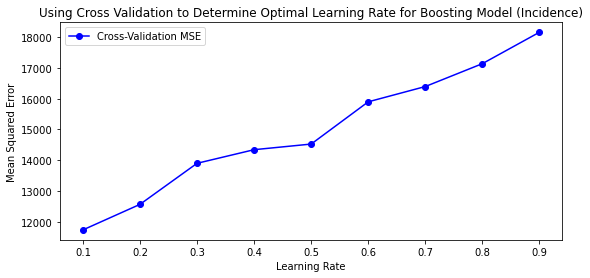

In [32]:
x = np.array(l_rates)
y = np.array(test_mse_i)

# Plotting MSEs at each learning rate
plt.figure(figsize = (9,4))
plt.ylabel("Mean Squared Error")
plt.xlabel("Learning Rate")
plt.title('Using Cross Validation to Determine Optimal Learning Rate for Boosting Model (Incidence)')
plt.plot(x, y, 'b-', marker='o', label = 'Cross-Validation MSE')
plt.xticks(x)
plt.legend(loc="upper left")
plt.show()

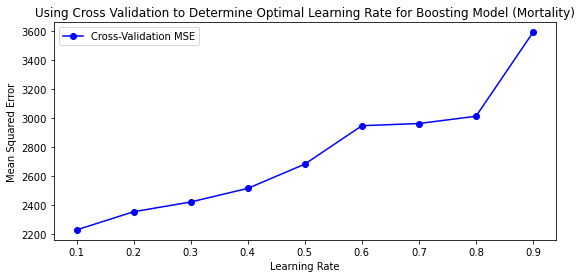

In [33]:
x = np.array(l_rates)
y = np.array(test_mse_m)

# Plotting MSEs at each learning rate
plt.figure(figsize = (9,4))
plt.ylabel("Mean Squared Error")
plt.xlabel("Learning Rate")
plt.title('Using Cross Validation to Determine Optimal Learning Rate for Boosting Model (Mortality)')
plt.plot(x, y, 'b-', marker='o', label = 'Cross-Validation MSE')
plt.xticks(x)
plt.legend(loc="upper left")
plt.show()

In [35]:

# Initialise Boosting Models for incidence and mortality using sklearn's boosting model  
# Use 1000 estimators, depth of 1 and optimal learning rates as found via cross validation above 
boosted_model_i = GradientBoostingRegressor(n_estimators=1000,max_depth=1,learning_rate=best_rate_i)
boosted_model_m = GradientBoostingRegressor(n_estimators=1000,max_depth=1,learning_rate=best_rate_m)

# Fit on the train data
boosted_model_i.fit(X_train_i,y_train_i)
boosted_model_m.fit(X_train_m,y_train_m)

# Predict on the test data
y_pred_i = boosted_model_i.predict(X_test_i)
y_pred_m = boosted_model_m.predict(X_test_m)

# Compute the MSE of the Boosting model prediction on the test data
boost_mse_i = mean_squared_error(y_test_i,y_pred_i)
print(f"The MSE of the Boosting model (incidence) is {boost_mse_i:.3f}")
boost_mse_m = mean_squared_error(y_test_m,y_pred_m)
print(f"The MSE of the Boosting model (mortality) is {boost_mse_m:.3f}")

# Compute the R-Squared of the Boosting model prediction on the test data
boosting_r2_i = r2_score(y_test_i, y_pred_i)
print(f"The R-Squared of the Boosting model (incidence) is {boosting_r2_i:.3f}")
boosting_r2_m = r2_score(y_test_m, y_pred_m)
print(f"The R-Squared of the Boosting model (mortality) is {boosting_r2_m:.3f}")

model_dict["boosting_incidence"] = [boost_mse_i, boosting_r2_i]
model_dict["boosting_morality"] = [boost_mse_m, boosting_r2_m]

The MSE of the Boosting model (incidence) is 10492.543
The MSE of the Boosting model (mortality) is 2968.460
The R-Squared of the Boosting model (incidence) is 0.422
The R-Squared of the Boosting model (mortality) is 0.368


In [36]:
model_dict

{'polynomial_incidence': [10996.430963026087, 0.3939484038919131],
 'polynomial_mortality': [3087.628360014328, 0.342865002218954],
 'lasso_incidence': [11264.117053141097, 0.37919529147611053],
 'lasso_mortality': [3085.608284794603, 0.34329493159200375],
 'decision_tree_incidence': [12240.119129876177, 0.32540441892855754],
 'decision_tree_mortality': [3332.2792611834907, 0.2907963428301076],
 'random_forest_incidence': [10394.164324527877, 0.4271414152218407],
 'random_forest_mortality': [2942.5090896745864, 0.37375050405838217],
 'bagging_incidence': [10367.975169510972, 0.42858479073632216],
 'bagging_mortality': [3038.6860502889617, 0.3532813155969762],
 'boosting_incidence': [10492.543182349917, 0.42171941384641176],
 'boosting_morality': [2968.459637970732, 0.368227490434772]}